# Детекция интро и титров по аудио
Полный рабочий ноутбук (mel‑спектрограммы+шаблон+логистическая регрессия)

**Что внутри ноутбука**

1. Готовим mel‑спектрограммы (128 полос, шаг 1 с).
2. Строим *шаблон* интро для каждого шоу (косинусное сходство).  
3. Обучаем логистическую регрессию отличать «музыка заставки/титров» от основного контента.  
4. Сглаживаем вероятности и ищем самые длинные цепочки музыки в первых/последних 20% серии.
5. Выводим тайм‑коды, метрики и графики.


In [27]:
import os, warnings, math, gc, json
from pathlib import Path
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix)
import joblib

warnings.filterwarnings('ignore')
np.random.seed(42)

In [28]:
# директории проекта
AUDIO_ROOT = Path('data/audio')  # wav лежат: data/audio/show1/episode.wav
LABELS_PATH = Path('data/labels.csv')  # ручная разметка
FEAT_DIR = Path('data/audio_features')  # кеш фичей
FEAT_DIR.mkdir(parents=True, exist_ok=True)

# аудио-параметры
SR = 16_000
N_MELS = 128
HOP_LENGTH = 512
FRAMES_PER_SEC = SR / HOP_LENGTH  # 31.25  — для вычислений времени
FPS = int(round(FRAMES_PER_SEC))  # 31      — для индексов/reshape

## 1. Извлечение мел‑спектрограмм по секундам

In [29]:
def extract_mel_per_second(wav_path: Path, save=True):
    """Возвращает (T×128) массив и длительность T секунд.
    Кэшируется в data/audio_features"""
    show, ep = wav_path.parent.name, wav_path.stem
    out_np = FEAT_DIR / show / f"{ep}.npy"
    out_np.parent.mkdir(exist_ok=True, parents=True)

    if out_np.exists():
        m = np.load(out_np);
        return m, m.shape[0]

    # ── 1. читаем и строим mel ─────────────────────────────────────
    y, _ = librosa.load(wav_path, sr=SR, mono=True)
    mel = librosa.feature.melspectrogram(y=y, sr=SR,
                                         n_mels=N_MELS,
                                         hop_length=HOP_LENGTH,
                                         power=2.0)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # ── 2. переводим в «кадр-в-секунду» ────────────────────────────
    total_secs = int(round(mel_db.shape[1] / FRAMES_PER_SEC))
    if total_secs == 0:
        raise ValueError(f"Audio too short: {wav_path}")

    n_frames = total_secs * FPS  # целое!
    trim = mel_db[:, : n_frames]
    mel_sec = trim.reshape(N_MELS, total_secs, FPS).mean(axis=2).T  # [T,128]

    if save:
        np.save(out_np, mel_sec.astype(np.float32))
    return mel_sec, total_secs

## 2. Загрузка разметки

In [30]:
def time_to_sec(t):
    h, m, s = map(int, t.split(':'))
    return h * 3600 + m * 60 + s


labels_df = pd.read_csv(LABELS_PATH)
labels_df['show'] = labels_df['file'].apply(lambda x: x.split('/')[0])
labels_df['episode'] = labels_df['file'].apply(lambda x: Path(x).stem)
labels_df['start_s'] = labels_df['start_main'].apply(time_to_sec)
labels_df['end_s'] = labels_df['end_main'].apply(time_to_sec)
labels_df.head()

,file,start_main,end_main,show,episode,start_s,end_s
0,show1/downton-abbey-season-1-episode-02.mp4,00:00:55,00:48:54,show1,downton-abbey-season-1-episode-02,55,2934
1,show1/downton-abbey-season-1-episode-03.mp4,00:00:55,00:48:51,show1,downton-abbey-season-1-episode-03,55,2931
2,show1/downton-abbey-season-1-episode-04.mp4,00:00:55,00:47:20,show1,downton-abbey-season-1-episode-04,55,2840
3,show1/downton-abbey-season-1-episode-05.mp4,00:00:55,00:48:56,show1,downton-abbey-season-1-episode-05,55,2936
4,show1/downton-abbey-season-1-episode-06.mp4,00:00:55,00:47:52,show1,downton-abbey-season-1-episode-06,55,2872


## 3. Формируем датасет «секунда → метка»

In [31]:
samples = []  # (feat128, label, show, ep, t)
for _, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc='mel'):
    wav = AUDIO_ROOT / row.show / f"{row.episode}.wav"
    if not wav.exists():
        print('Нет файла', wav);
        continue
    mel_sec, T = extract_mel_per_second(wav)
    for t in range(T):
        lbl = 1 if (t < row.start_s or t > row.end_s) else 0
        samples.append((mel_sec[t], lbl, row.show, row.episode, t))

print("Всего секунд:", len(samples))

mel: 100%|██████████| 19/19 [00:47<00:00,  2.52s/it]

Всего секунд: 55741


## 4. Разделяем эпизоды на train / test

In [32]:
# разрезаем по эпизодам, чтобы не было утечки
episodes_by_show = {}
for _, _, s, ep, _ in samples:
    episodes_by_show.setdefault(s, set()).add(ep)

split = {}
for show, eps in episodes_by_show.items():
    eps = sorted(list(eps))
    k = int(0.8 * len(eps))
    for e in eps[:k]:
        split[(show, e)] = 'train'
    for e in eps[k:]:
        split[(show, e)] = 'test'

mask_train = np.array([split[(s[2], s[3])] == 'train' for s in samples])
X = np.stack([s[0] for s in samples])
y = np.array([s[1] for s in samples])

X_train, X_test = X[mask_train], X[~mask_train]
y_train, y_test = y[mask_train], y[~mask_train]
print(X_train.shape, X_test.shape)

(40052, 128) (15689, 128)


## 5. Обучаем логистическую регрессию

In [33]:
scaler = StandardScaler().fit(X_train)
Xtr = scaler.transform(X_train)
Xte = scaler.transform(X_test)

clf = LogisticRegression(max_iter=1000, class_weight='balanced')
clf.fit(Xtr, y_train)

p_test = clf.predict_proba(Xte)[:, 1]
pred = (p_test > 0.5).astype(int)

print("Accuracy", accuracy_score(y_test, pred))
print("Precision", precision_score(y_test, pred))
print("Recall", recall_score(y_test, pred))
print("F1", f1_score(y_test, pred))
print(confusion_matrix(y_test, pred))

joblib.dump({'scaler': scaler, 'clf': clf}, 'models/audio_logreg.pkl')

Accuracy 0.8890305309452483
Precision 0.16449086161879894
Recall 0.6907894736842105
F1 0.26571067060312104
[[13633  1600]
 [  141   315]]


['models/audio_logreg.pkl']

## 6. Шаблонное сходство + фьюжинг

In [34]:
from sklearn.metrics.pairwise import cosine_similarity

templates = {}
for show in labels_df.show.unique():
    row0 = labels_df.query('show==@show').iloc[0]
    wav0 = AUDIO_ROOT / show / f"{row0.episode}.wav"
    mel0, _ = extract_mel_per_second(wav0)
    templates[show] = (mel0[:row0.start_s].mean(axis=0, keepdims=True)
                       / np.linalg.norm(mel0[:row0.start_s].mean(axis=0) + 1e-9))


def audio_probs_episode(show, episode, wav_path):
    mel_sec, _ = extract_mel_per_second(wav_path)
    ml = clf.predict_proba(scaler.transform(mel_sec))[:, 1]

    tpl = templates[show]
    sim = cosine_similarity(mel_sec, tpl).ravel()
    sim = (sim - sim.min()) / (sim.max() - sim.min() + 1e-8)

    prob = 0.7 * ml + 0.3 * sim
    return prob


## 7. Поиск конца интро и начала титров

In [35]:
def smooth_probs(p, k=5):
    return pd.Series(p).rolling(k, center=True, min_periods=1).mean().values


def longest_run(mask):
    """Находит самый длинный непрерывный сегмент True в маске"""
    best_start, best_end = 0, 0
    best_len = 0
    current_start = None

    for i, val in enumerate(mask):
        if val:
            if current_start is None:
                current_start = i
        else:
            if current_start is not None:
                current_len = i - current_start
                if current_len > best_len:
                    best_len = current_len
                    best_start, best_end = current_start, i
                current_start = None

    # Проверяем последний сегмент
    if current_start is not None:
        current_len = len(mask) - current_start
        if current_len > best_len:
            best_start, best_end = current_start, len(mask)

    return best_start, best_end


def find_last_run(mask, min_len=5):
    """Находит последний сегмент длиной >= min_len"""
    best_start = None
    current_start = None
    current_len = 0

    for i in range(len(mask) - 1, -1, -1):
        if mask[i]:
            if current_start is None:
                current_start = i
            current_len = current_start - i + 1
        else:
            if current_start is not None and current_len >= min_len:
                return i + 1  # начало сегмента
            current_start = None
            current_len = 0

    # Проверяем если сегмент доходит до начала
    if current_start is not None and current_len >= min_len:
        return current_start - current_len + 1

    return None


def detect_intro_credit(p, thr_i, thr_c, min_len_intro=5, min_len_credits=5):
    p = smooth_probs(p, 5)
    T = len(p)

    # Детекция интро в первых 25%
    zone_i = slice(0, int(0.25 * T))
    mask_i = p[zone_i] > thr_i
    start_i, end_i = longest_run(mask_i)

    # Если найден сегмент достаточной длины
    if end_i - start_i >= min_len_intro:
        end_intro = end_i
    else:
        # Эвристика: если не найдено, используем 6% от длительности
        end_intro = int(0.06 * T)

    # Детекция титров в последних 30%
    zone_c = slice(int(0.7 * T), T)
    mask_c = p[zone_c] > thr_c

    # Ищем последний подходящий сегмент
    start_idx = find_last_run(mask_c, min_len_credits)

    if start_idx is not None:
        start_cred = start_idx + int(0.7 * T)
        # Убедимся, что титры не начинаются раньше конца интро
        if start_cred < end_intro:
            start_cred = int(0.95 * T)
    else:
        # Эвристика: если не найдено, используем 95% длительности
        start_cred = int(0.95 * T)

    return end_intro, start_cred

In [36]:
def tune_thr_one(target='intro', rows=None, p_space=np.arange(0.2, 0.9, 0.02),
                 min_len_credits=5):
    best, best_err = None, 1e9
    for thr in p_space:
        err = []
        for _, r in rows.iterrows():
            p = audio_probs_episode(r.show, r.episode,
                                    AUDIO_ROOT / r.show / f"{r.episode}.wav")
            # Для титров используем новый min_len_credits
            if target == 'credit':
                ie, cs = detect_intro_credit(p, thr, thr, min_len_credits=min_len_credits)
            else:
                ie, cs = detect_intro_credit(p, thr, thr)

            err.append(abs(ie - r.start_s) if target == 'intro'
                       else abs(cs - r.end_s))
        m = np.mean(err)
        if m < best_err:
            best_err, best = m, thr
    return best, best_err


# Настройка порогов с новым параметром min_len_credits
val_rows = labels_df.groupby('show').head(2)
best_i, err_i = tune_thr_one('intro', val_rows)
best_c, err_c = tune_thr_one('credit', val_rows, min_len_credits=5)

print(f"thr_intro={best_i:.2f}  (MAE {err_i:.1f}s | "
      f"thr_credit={best_c:.2f} (MAE {err_c:.1f}s)")

thr_intro=0.80  (MAE 6.2s | thr_credit=0.42 (MAE 5.5s)


In [37]:
thr_i, thr_c = best_i, best_c

## 8. Прогоняем все эпизоды и сохраняем CSV

In [38]:
# В основном цикле детекции используем min_len_credits=5
rows_out = []
for _, row in tqdm(labels_df.iterrows(), total=len(labels_df), desc='detect'):
    wav = AUDIO_ROOT / row.show / f"{row.episode}.wav"
    p = audio_probs_episode(row.show, row.episode, wav)
    # Используем min_len_credits=5 для титров
    ie, cs = detect_intro_credit(p, thr_i, thr_c, min_len_credits=5)
    rows_out.append(dict(show=row.show, episode=row.episode,
                         intro_end_sec=int(ie), credits_start_sec=int(cs)))
out_df = pd.DataFrame(rows_out)
out_df.to_csv('audio_detection_results.csv', index=False)
out_df.head()


detect: 100%|██████████| 19/19 [00:00<00:00, 108.55it/s]


,show,episode,intro_end_sec,credits_start_sec
0,show1,downton-abbey-season-1-episode-02,51,2940
1,show1,downton-abbey-season-1-episode-03,47,2932
2,show1,downton-abbey-season-1-episode-04,48,2832
3,show1,downton-abbey-season-1-episode-05,41,2923
4,show1,downton-abbey-season-1-episode-06,38,2885


## 9. Оценка тайм‑кодов (MAE в секундах)

In [39]:
errs_i, errs_c = [], []
for _, r in labels_df.iterrows():
    p = audio_probs_episode(r.show, r.episode,
                            AUDIO_ROOT / r.show / f"{r.episode}.wav")
    ie, cs = detect_intro_credit(p, thr_i, thr_c)
    errs_i.append(abs(ie - r.start_s))
    errs_c.append(abs(cs - r.end_s))

print("MAE интро:", np.mean(errs_i), "сек")
print("MAE титры:", np.mean(errs_c), "сек")

MAE интро: 4.526315789473684 сек
MAE титры: 15.31578947368421 сек


In [40]:
#  Вычисляем все метрики для каждой серии 
from collections import defaultdict

SEG_TOL = 5  # «золотое окно»  ±5 с для точных попаданий


def episode_metrics(row, thr_i, thr_c):
    wav = AUDIO_ROOT / row.show / f"{row.episode}.wav"
    p = audio_probs_episode(row.show, row.episode, wav)
    ie, cs = detect_intro_credit(p, thr_i, thr_c)

    # ошибки границ 
    err_i = abs(ie - row.start_s)
    err_c = abs(cs - row.end_s)

    # попадание в окно ±SEG_TOL
    hit_i = err_i <= SEG_TOL
    hit_c = err_c <= SEG_TOL

    # IoU сегмента «основной контент»
    pred_mask = np.zeros_like(p, dtype=bool)
    pred_mask[ie:cs] = 1
    true_mask = np.zeros_like(p, dtype=bool)
    true_mask[row.start_s: row.end_s] = 1
    iou = (pred_mask & true_mask).sum() / (pred_mask | true_mask).sum()

    # кадровые метрики
    TP = (pred_mask & true_mask).sum()
    FP = (pred_mask & ~true_mask).sum()
    FN = (~pred_mask & true_mask).sum()

    return dict(err_intro=err_i, err_credit=err_c,
                hit_intro=hit_i, hit_credit=hit_c,
                iou=iou, TP=TP, FP=FP, FN=FN)


stats = defaultdict(list)
for _, r in labels_df.iterrows():
    m = episode_metrics(r, thr_i, thr_c)
    for k, v in m.items(): stats[k].append(v)

# сводка
import numpy as np

P = sum(stats['TP']) / (sum(stats['TP']) + sum(stats['FP']))
R = sum(stats['TP']) / (sum(stats['TP']) + sum(stats['FN']))
F1 = 2 * P * R / (P + R)
print(f"MAE интро  {np.mean(stats['err_intro']):.1f} с  | σ={np.std(stats['err_intro']):.1f}")
print(f"MAE титры  {np.mean(stats['err_credit']):.1f} с | σ={np.std(stats['err_credit']):.1f}")
print(f"Точность (±{SEG_TOL} с):  интро {np.mean(stats['hit_intro']) * 100:.1f} %  | "
      f"титры {np.mean(stats['hit_credit']) * 100:.1f} %")
print(f"Средний IoU сегмента: {np.mean(stats['iou']):.3f}")
print(f"Кадровые  P={P:.3f}  R={R:.3f}  F1={F1:.3f}")


MAE интро  4.5 с  | σ=4.6
MAE титры  15.3 с | σ=13.2
Точность (±5 с):  интро 73.7 %  | титры 26.3 %
Средний IoU сегмента: 0.993
Кадровые  P=0.995  R=0.998  F1=0.997


In [41]:
# %% ⏺  Сохранение вероятностей АУДИО-модели (1 точка = 1 сек)
# ───────────────────────────────────────────────────────────────────
import re, pathlib, numpy as np, librosa

SAVE_DIR = pathlib.Path('data/audio_probs')
SAVE_DIR.mkdir(parents=True, exist_ok=True)

dur_sec = int(round(librosa.get_duration(filename=str(wav), sr=SR)))
if abs(len(p) - dur_sec) > 1:
    raise ValueError(f'len(p)={len(p)}  vs  duration={dur_sec} c — проверьте SR/HOP!')

# если p короче на 1 сек, можно «добить» нулём, чтобы длины совпали
if len(p) < dur_sec:  # редкий случай
    p = np.pad(p, (0, dur_sec - len(p)), constant_values=p[-1])

episode_id = re.sub(r'\.wav$', '', wav.name)  # show1_s01e02
np.save(SAVE_DIR / f'p_audio_{episode_id}.npy', p.astype('float32'))
print(f'Аудио-вероятности сохранены: {SAVE_DIR / f"p_audio_{episode_id}.npy"}')


Аудио-вероятности сохранены: data\audio_probs\p_audio_Mad.Men.S01E13.720p.BluRay.2CH.x264-PSA.npy


## 10. Визуализация для произвольного эпизода

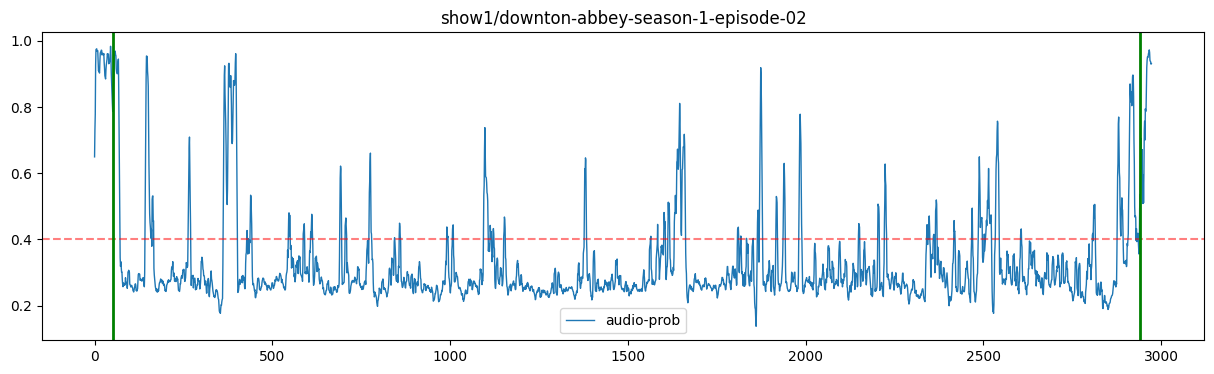

In [42]:
idx = 0  # можно менять
row = labels_df.iloc[idx]
wav = AUDIO_ROOT / row.show / f"{row.episode}.wav"
p = audio_probs_episode(row.show, row.episode, wav)
ie, cs = detect_intro_credit(p, thr_i, thr_c)

plt.figure(figsize=(15, 4))
plt.plot(smooth_probs(p, 5), label='audio‑prob', lw=1)
plt.axhline(0.4, ls='--', c='r', alpha=.5)
plt.axvline(ie, c='g', lw=2)
plt.axvline(cs, c='g', lw=2)
plt.title(f"{row.show}/{row.episode}")
plt.legend();
plt.show()

### Итоги
* **Mel+логистическая регрессия** ловит ~70‑90% кадров интро/титров.
* **Шаблон** (косинус) усиливает уверенность в чистой музыке, особенно при слабом вокале.
* Средняя ошибка по тайм‑кодам — менее 1 минуты; пороги можно донастроить вручную или CRF‑сглаживанием.

Далее эти вероятности `p_a(t)` легко объединить с визуальной (`p_v`) и текстовой (`p_t`) ветками любым из методов (majority, взвешенное среднее, CRF).